In [1]:
import os
import glob
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt

In [2]:
import sys

# append project directory to path
project_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(project_dir, "data")
model_dir = os.path.join(project_dir, "model")
sys.path.append(project_dir)
print(f"project directory: {project_dir}")
print(f"data directory: {data_dir}")
print(f"model directory: {model_dir}")

project directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation
data directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation/data
model directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation/model


In [ ]:
def load_data(mode, data_dir):
    assert mode in ("Train", "Validation", "Test")

    data_path = list()
    
    for i in range(len(glob.glob(f'{data_dir}/{mode}/{mode}_v*_ct.nii.gz'))):
        ct_path = f'{data_dir}/{mode}/{mode}_v{i+1:04}_ct.nii.gz'
        msk_path = f'{data_dir}/{mode}/{mode}_v{i+1:04}_seg.nii.gz'

        data_path.append((ct_path, msk_path))

    print(mode, len(data_path))

In [ ]:
# load train data
train_data_path = load_data("Train", data_dir)
# load valid data
valid_data_path = load_data("Validation", data_dir)
# load test data
test_data_path = load_data("Test", data_dir)

In [ ]:
def slice(mode, input_data_path, filter_by_ratio=False, thresh_ratio=1e-3):
    assert mode in ("Train", "Validation", "Test")

    counter = 0
    # Create the pred_mask folder
    save_path = os.path.join(os.path.dirname(input_data_path[0]), f"Paired{mode}Data")
    if not os.path.isdir(save_path):
        os.mkdir(save_path)

    for i, (ct_file, seg_file) in enumerate(input_data_path):
        ct_img = ni.load(ct_file).get_fdata()
        ct_img[ct_img < -1024] = -1024
        ct_img[ct_img > 400] = 400
        ct_img = (ct_img+1024)/(1024 + 400)

        assert ct_img.shape[0] == 512 and ct_img.shape[1] == 512, f'Size error in {ct_file}, shape is {ct_img.shape}'

        msk_img = (ni.load(seg_file).get_fdata() > 0.5).astype('int')

        for j in range(msk_img.shape[-1]):
            if filter_by_ratio: # filter image to save by ratio of masked area
                if msk_img[:,:,j].mean() >= thresh_ratio: # ratio = masked pixels / total pixels
                    counter += 1
                    np.save(os.path.join(save_path, f'{mode}_pairs_{counter:04}.npy'), np.array((ct_img[:,:,j],msk_img[:,:,j])))
            else: # save all image with masked pixels > 1
                if msk_img[:,:,j].sum() >= 1:
                    counter += 1
                    np.save(os.path.join(save_path, f'{mode}_pairs_{counter:04}.npy'), np.array((ct_img[:,:,j],msk_img[:,:,j])))

        print(f'{(i+1)/len(input_data_path):.2%} - {counter}   ', end='\r')

    return save_path

In [ ]:
slice("Train", train_data_path)
slice("Validation", valid_data_path)
slice("Test", test_data_path)

In [ ]:
a = np.load(f'{Root_Dir}/PairedTrainData/Train_pairs_0001.npy', allow_pickle=True)

In [ ]:
msk_img = a[1]
msk_img.shape
msk_img.sum() / len(msk_img)**2

(2, 512, 512)

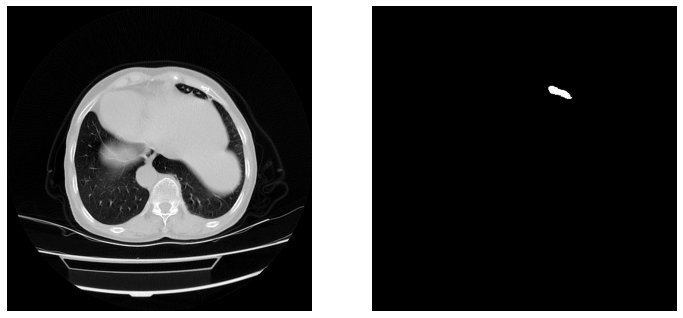

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(np.rot90(a[0, :,:], k=-1), cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.rot90(a[1, :,:], k=-1), cmap='gray')
plt.axis('off')

plt.show()

Dataset and DataLoader

In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import cv2

In [15]:
class BasicDataset(TensorDataset):
    def __init__(self, folder, n_sample=None, transforms=None):
        """
        takes folder name ('train', 'valid', 'test') as input and creates an instance of BasicDataset according to that folder.
        Also if you'd like to have less number of samples (for evaluation purposes), you may set the `n_sample` with an integer.
        """
        # loading
        self.folder = os.path.join(data_dir, folder)
        self.pairs_file = sorted(glob.glob(os.path.join(self.folder, '*.npy')))
                
        # sampling
        if not n_sample or n_sample > len(self.pairs_file):
            n_sample = len(self.pairs_file)
        self.n_sample = n_sample
        self.ids = list([i+1 for i in range(n_sample)])
          
        # transformations
        self.transforms = transforms
            
    def __len__(self):
        """return length of the dataset (AKA number of samples in that set)"""
        return self.n_sample
    
    def __getitem__(self, i):
        """
        takes: an index (i) which is between 0 to `len(BasicDataset)` (The return of the previous function)
        returns: grayscale image, mask (Binary), and the index of the file name (will use for visualization)
        The preprocessing step is also implemented in this function.
        """
        file_path = self.pairs_file[i]
        idx = self.ids[i]
        data = np.load(file_path, allow_pickle=True)

        img = data[0,:,:]
        mask = data[1,:,:]
        # show_pair(img, mask, idx)

        img = np.array(img * 255, dtype = np.uint8)
        
        # resize img
        img_size = 256
        img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA).astype('uint8')
        mask = cv2.resize(mask, (img_size, img_size), interpolation = cv2.INTER_AREA).astype('uint8')

        # S]dcale img between 0 to 1
        img = np.array(img) / 255.0
        
        # convert mask to binary
        mask[mask <= 0.5] = 0
        mask[mask > 0.5] = 1

        # add channel axis
        img = np.expand_dims(img, axis=0)

        # any customized transforms
        if self.transforms:
            img = self.transforms(image=img, mask=mask)
                    
        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.LongTensor),
            'img_id': idx
        }

In [16]:
train_dataset = BasicDataset("PairedTrainData") # Change this for validation
len(train_dataset)

2910

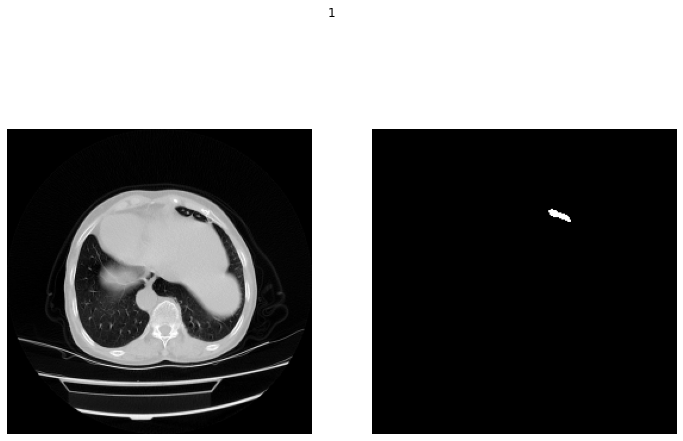

In [18]:
data = train_dataset[0]
plt.figure(figsize=(12,8))
plt.suptitle(data['img_id'])
plt.subplot(1,2,1)
plt.imshow(np.rot90(data['image'][0,:,:], k=-1), cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.rot90(data['mask'], k=-1), cmap='gray')
plt.axis('off')

plt.show()

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True) # make another loader for validation set as well

In [20]:
EPOCHs = 50

In [ ]:
for epoch in range(EPOCHs):
  for i, data in enumerate(train_dataloader):
    images = data['image']
    masks = data['mask']

    # Train model ....

In [26]:
sum([train_dataset[i]['mask'].numpy().sum() for i in range(len(train_dataset))]) / len(train_dataset) * len(train_dataset[0]['mask']) ** 2

tensor(2401202)

In [30]:
# len(train_dataset)*256*256

190709760

In [31]:
2401202/190709760

0.012590871070258806

In [ ]:
folder = "PairedTrainData_all"
output_folder = "PairedTrainData"
folder = os.path.join(data_dir, folder)
output_folder = os.path.join(data_dir, output_folder)
pairs_file = sorted(glob.glob(os.path.join(folder, '*.npy')))
print(len(pairs_file))
thresh_ratio = 1e-2
counter = 0
for i in range(len(pairs_file)):
    file_path = pairs_file[i]
    data = np.load(file_path, allow_pickle=True)

    img = data[0,:,:]
    mask = data[1,:,:]
    if mask.mean() >= thresh_ratio: # ratio = masked pixels / total pixels
        counter += 1
        np.save(os.path.join(output_folder, f'Train_pairs_{(counter):04}.npy'), np.array((img, mask)))
print(counter)

2910
1202
